In [1]:
from jax_md import *
import jax
import jax.random as jr
import jax.numpy as jnp
import matplotlib.pyplot as plt

# jax.config.update("jax_enable_x64", True)

In [2]:
dim = 2
N = 256
box_size = quantity.box_size_at_number_density(N, 1, dim)

In [3]:
displacement, shift = space.periodic(box_size)
metric = space.metric(displacement)
v_displacement = space.map_product(displacement)
v_metric = space.map_product(metric)

My way of doing a brownian simulation, and saving the state at every timestep

In [4]:
def brownian_simulation(key, temperature, dt, steps, energy_fn):
    pos_key, sim_key, times_key = jr.split(key, 3)
    # R = jr.uniform(pos_key, (N, 2), maxval=box_size)
    R = jnp.ones((N, 2))*0.5*box_size

    init_fn, apply_fn = simulate.brownian(energy_fn, shift, dt, temperature)
    initial_state = init_fn(sim_key, R)
    state = init_fn(sim_key, R)

    do_step = lambda state, t: (apply_fn(state), apply_fn(state))
    final_state, intermediate_states = jax.lax.scan(do_step, state, steps)

    return initial_state.position, final_state.position, intermediate_states.position, times_key

In [5]:
initial, final, intermediate, times_key = brownian_simulation(jr.PRNGKey(0), 0.05, 0.01, jnp.arange(1000), lambda r: 0.)

In [6]:
final = jnp.expand_dims(final, 0)
initial = jnp.expand_dims(initial, 0)
all_states = jnp.concatenate((initial, intermediate, final), axis=0)
print(jnp.shape(all_states))

(1002, 256, 2)


In [7]:
correction = 0.5*box_size*jnp.ones_like(all_states)

In [8]:
all_states = all_states - correction

In [9]:
@jax.vmap
def compute_norm(positions):
    return jnp.sqrt(positions[:, 0]**2 + positions[:, 1]**2)

In [10]:
norms = compute_norm(all_states)

In [11]:
print(jnp.shape(norms))

(1002, 256)


In [17]:
dr = box_size/1000
rr = jnp.arange(dr, box_size+dr, dr)
def compute_g_quick(norms, length):
    # set zeros to length+1 so bincount ignores 
    bins = jnp.floor(norms/dr).astype(int)
    return jnp.bincount(bins.flatten(), length=length)
compute_g_quick = jax.vmap(compute_g_quick, in_axes=(0, None))

In [18]:
g_test = compute_g_quick(norms, 1000)

In [19]:
print(jnp.shape(g_test))

(1002, 1000)


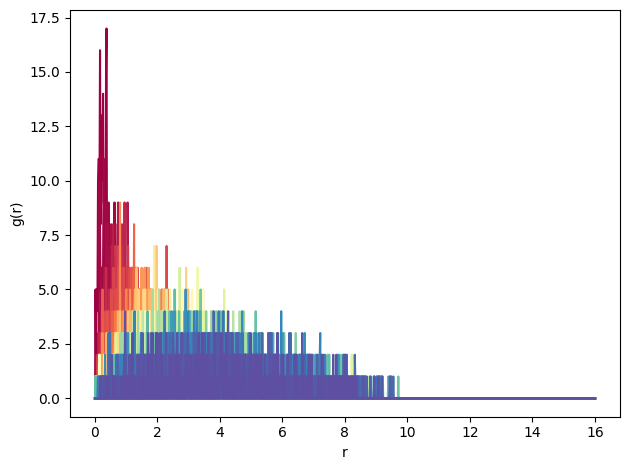

In [24]:
from cycler import cycler
fig, ax = plt.subplots()
custom_cycler = cycler("color", plt.cm.Spectral(jnp.linspace(0, 1, 1000//10)))
ax.set_prop_cycle(custom_cycler)
ks = jnp.arange(5, 1002, 10)
for k in ks:
    ax.plot(rr, g_test[k, :])
ax.set_xlabel("r")
ax.set_ylabel("g(r)")
#ax.set_ylim([0, 1000])
plt.tight_layout()
plt.savefig("2d_bm_torus_initial_concpoint_time__other_density_rdf.png", dpi=300)
plt.show()

In [129]:
print(rdf_avg)

[6.30000055e-01 1.00200009e+00 1.40800011e+00 1.80800009e+00
 2.19600010e+00 2.66200018e+00 2.94200015e+00 3.50400019e+00
 3.95600009e+00 4.25800037e+00 4.69400024e+00 5.06200027e+00
 5.41600037e+00 6.02800035e+00 6.43000031e+00 6.68600035e+00
 7.39800024e+00 7.44000053e+00 8.07400036e+00 8.51800060e+00
 9.05800056e+00 9.34400082e+00 9.51600075e+00 9.95000076e+00
 1.04280005e+01 1.06900005e+01 1.13220005e+01 1.18120003e+01
 1.19120007e+01 1.24620008e+01 1.28380003e+01 1.31760006e+01
 1.35980005e+01 1.42080011e+01 1.48560009e+01 1.48820009e+01
 1.51800003e+01 1.58860006e+01 1.60640011e+01 1.67180004e+01
 1.67960014e+01 1.74240017e+01 1.76160011e+01 1.81459999e+01
 1.85840015e+01 1.90340004e+01 1.95800018e+01 1.98640003e+01
 2.03200016e+01 2.07200012e+01 2.10020008e+01 2.19160004e+01
 2.21100006e+01 2.24060001e+01 2.29220009e+01 2.32940006e+01
 2.37920017e+01 2.43900013e+01 2.45040016e+01 2.49040012e+01
 2.53240013e+01 2.56160011e+01 2.62040005e+01 2.65740013e+01
 2.68320007e+01 2.723200